A transportation company aims to gain insights into the behavior patterns of their drivers. The goal is to develop a compensation policy that reflects driver productivity. Given the availability of data on drivers' trips through a fleet tracking app, we propose creating a model that categorizes trips into clusters, reflecting different types of driver behavior.
Our methodology will unfold in the following steps:

1. **Data Importing**: We will first bring in the trip and the driver data  for our analysis.

2. **Data Cleaning**: This step involves refining the dataset and  ensuring that the information is reliable and ready for analysis.

3. **Data Aggregation**: We will group data based on certain criteria, which will involve categorizing data by drivers and dates of the trips.

4. **Exploratory Data Analysis**: This is our first pass through the dataset where we will identify patterns, spot anomalies, and test hypotheses.

5. **Feature Engineering**: We will identify and create new indicators based on existing data that can better represent the underlying problem to the models.

6. **Preprocessing**: Before we apply our algorithm, we will preprocess the data, which could involve scaling features or encoding categorical variables.

7. **Dimensionality Reduction**: If we have a high number of features, we may apply techniques to reduce the number of input variables, such as Principal Component Analysis (PCA).

8. **Model Training and Cross Validation**: We will train our clustering model using the prepared data and validate its performance using cross-validation techniques to ensure our model is robust and reliable.

9. **Results Presentation**: Finally, we will organize and present our findings, which will include the different clusters of driver behavior and potentially their implications on productivity.

In [2]:
# importing dependancies
import datetime
import numpy as np
import pandas as pd
import re
from datetime import timedelta
import pytz # for timezone


from sklearn.preprocessing import StandardScaler
#Algorithm
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
#visuals
import seaborn as sns
import matplotlib.pyplot as plt




### Loading Data
in this phase of our analysis, we load two datasets from the fleet tracking application, namely, the drivers list and the trips dataset. We utilize the pandas library to load and process our data.



In [3]:
driver_data = pd.read_csv("Data/driver_data .csv")
trip_data = pd.read_csv("Data/trip_data (3).csv")


### Data Preparation
After loading the data, the next step is preparing it for analysis. From the 'trip_data' dataframe, we select only the relevant columns for our investigation. Additionally, to avoid confusion later in the analysis, we rename the 'id' column in the trip data to 'trip_id'.
(please explore your data to make you grab all the relevent features) 

In [4]:
Trips = trip_data[['id', 'start', 'stop', 'stopDuration', 'driver', 'averageSpeed', 'distance', 'drivingDuration','stopPoint']].copy()
Trips = Trips.rename(columns={'id': 'trip_id'})


The 'driver' and 'stopPoint' columns contain dictionaries. To simplify our analysis, we extract the necessary information from these columns and drop the original columns. This process includes transforming some of the extracted data into numeric types. 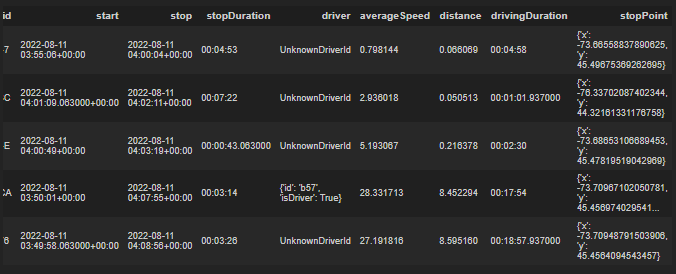

In [5]:

# Regex patterns
pattern_id = r"'id': '(\w+)'"
pattern_y = r"'y': (-?\d+\.\d+)"
pattern_x = r"'x': (-?\d+\.\d+)"

# Extraction
Trips['id'] = Trips['driver'].str.extract(pattern_id, expand=False)
Trips['stopPoint_y'] = Trips['stopPoint'].str.extract(pattern_y, expand=False)
Trips['stopPoint_x'] = Trips['stopPoint'].str.extract(pattern_x, expand=False)

# Converting the extracted 'stopPoint_y' and 'stopPoint_x' to float datatype
Trips['stopPoint_y'] = pd.to_numeric(Trips['stopPoint_y'])
Trips['stopPoint_x'] = pd.to_numeric(Trips['stopPoint_x'])

# Drop the 'driver' column


Dates and durations in our data are represented as strings. We convert these into more manageable formats, such as Python's timedelta for durations and Timestamp objects for dates and times.

In [6]:
#let us define a fonction to convert string format to timedelta object.
def parse_duration(duration_str):
    days, hours, minutes, seconds = 0, 0, 0, 0
    match = re.match(r'(\d+)\.(\d+):(\d+):(\d+)', duration_str)
    if match:
        days, hours, minutes, seconds = map(int, match.groups())
    else:
        match = re.match(r'(\d+):(\d+):(\d+)', duration_str)
        if match:
            hours, minutes, seconds = map(int, match.groups())
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
# We convert the 'stopDuration' and 'drivingDuration' columns from string format to timedelta objects using our function,
Trips['stopDuration'] = Trips['stopDuration'].apply(parse_duration)
Trips['drivingDuration'] = Trips['drivingDuration'].apply(parse_duration)


In [7]:
# We convert 'start' and 'stop' columns into Timestamp objects 
Trips["start"] = pd.to_datetime(Trips["start"])
Trips["stop"] = pd.to_datetime(Trips["stop"])
# and transform the 'drivingDuration' column into the number of hours

Trips["avg_drivingDuration"]=Trips["drivingDuration"].dt.total_seconds()/3600  # convert to hours
Trips["avg_stopDuration"]=Trips["stopDuration"].dt.total_seconds()/3600 
#we save another value of the drivingDuration that will be aggregated differently
Trips["hours driving"] =Trips["drivingDuration"].dt.total_seconds()/3600 
#We also extract the date and time components from the 'start' and 'stop' columns into separate columns.
Trips['start_date'] = Trips['start'].dt.date
Trips['start_time'] = Trips['start'].dt.time
Trips['stop_date'] = Trips['stop'].dt.date
Trips['stop_time'] = Trips['stop'].dt.time


We also change the timezone to our region.

In [8]:
# Convert to a different timezone
Trips['start'] =Trips['start'].dt.tz_convert('US/Eastern')
Trips['stop'] =Trips['stop'].dt.tz_convert('US/Eastern')

### Data Aggregation
We summarize the trip data on a daily basis for each driver using the groupby function. The agg function is then used to perform several aggregation operations such as count, max, min, sum, and mean on the relevant columns.

Then, we merge this summarized data with the driver_data dataframe to include driver names in the final summary.


In [9]:
Trips = Trips.dropna(subset=['id'])


In [10]:
# Define a function to calculate range (max - min) for the stop points
def range_func(data):
    return data.max() - data.min()
#summarise using per ID and date
summary_trips = Trips.groupby(["id",Trips["start_date"]]).agg({'trip_id':"count",
                                                               'stop_time': 'max',
                                                               'start_time': 'min',                                                        
                                                               "distance" : "sum"
                                                               ,"averageSpeed": "mean",
                                                               'trip_id': "count",
                                                               'hours driving':"sum",
                                                               "avg_drivingDuration":"mean",
                                                               "avg_stopDuration":"mean",
                                                               'stopPoint_x':range_func,
                                                               'stopPoint_y':range_func,
                                                               'start':'min',
                                                               'stop': 'max'
                                                        
                                                              }).reset_index()

summary_trips['stop_area'] = summary_trips["stopPoint_x"].astype(float) * summary_trips['stopPoint_y'].astype(float)*10000
summary_trips=summary_trips.drop(['stopPoint_y','stopPoint_x'], axis= 1)
summary_trips = summary_trips.merge(driver_data[['id', 'Name']], on='id')
Final_df = summary_trips.copy()

### Exploratory data analysis
As we delve into the 'Exploratory Data Analysis' phase, I'll put to use some fundamental statistical tools to assess the key features in our dataset. This analysis helps us understand the distribution of these features, which is essential for choosing the most suitable clustering algorithm for this project. The subsequent code that I'll run will generate informative visualizations in the form of box plots and histograms. These visual aids provide a clearer picture of the data's landscape. 

Moreover, I suspect that some features might be correlated. To illustrate these potential relationships, I'll also generate a heatmap. This visualization offers an overview of the correlations between different features in our dataset, allowing us to better understand the intricacies of our data.

This piece of code conducts an initial exploratory data analysis and generates a PDF report. You can consider this as a preliminary report that can be handed over to any stakeholders interested in understanding the data at hand. Please feel free to add mor variables 

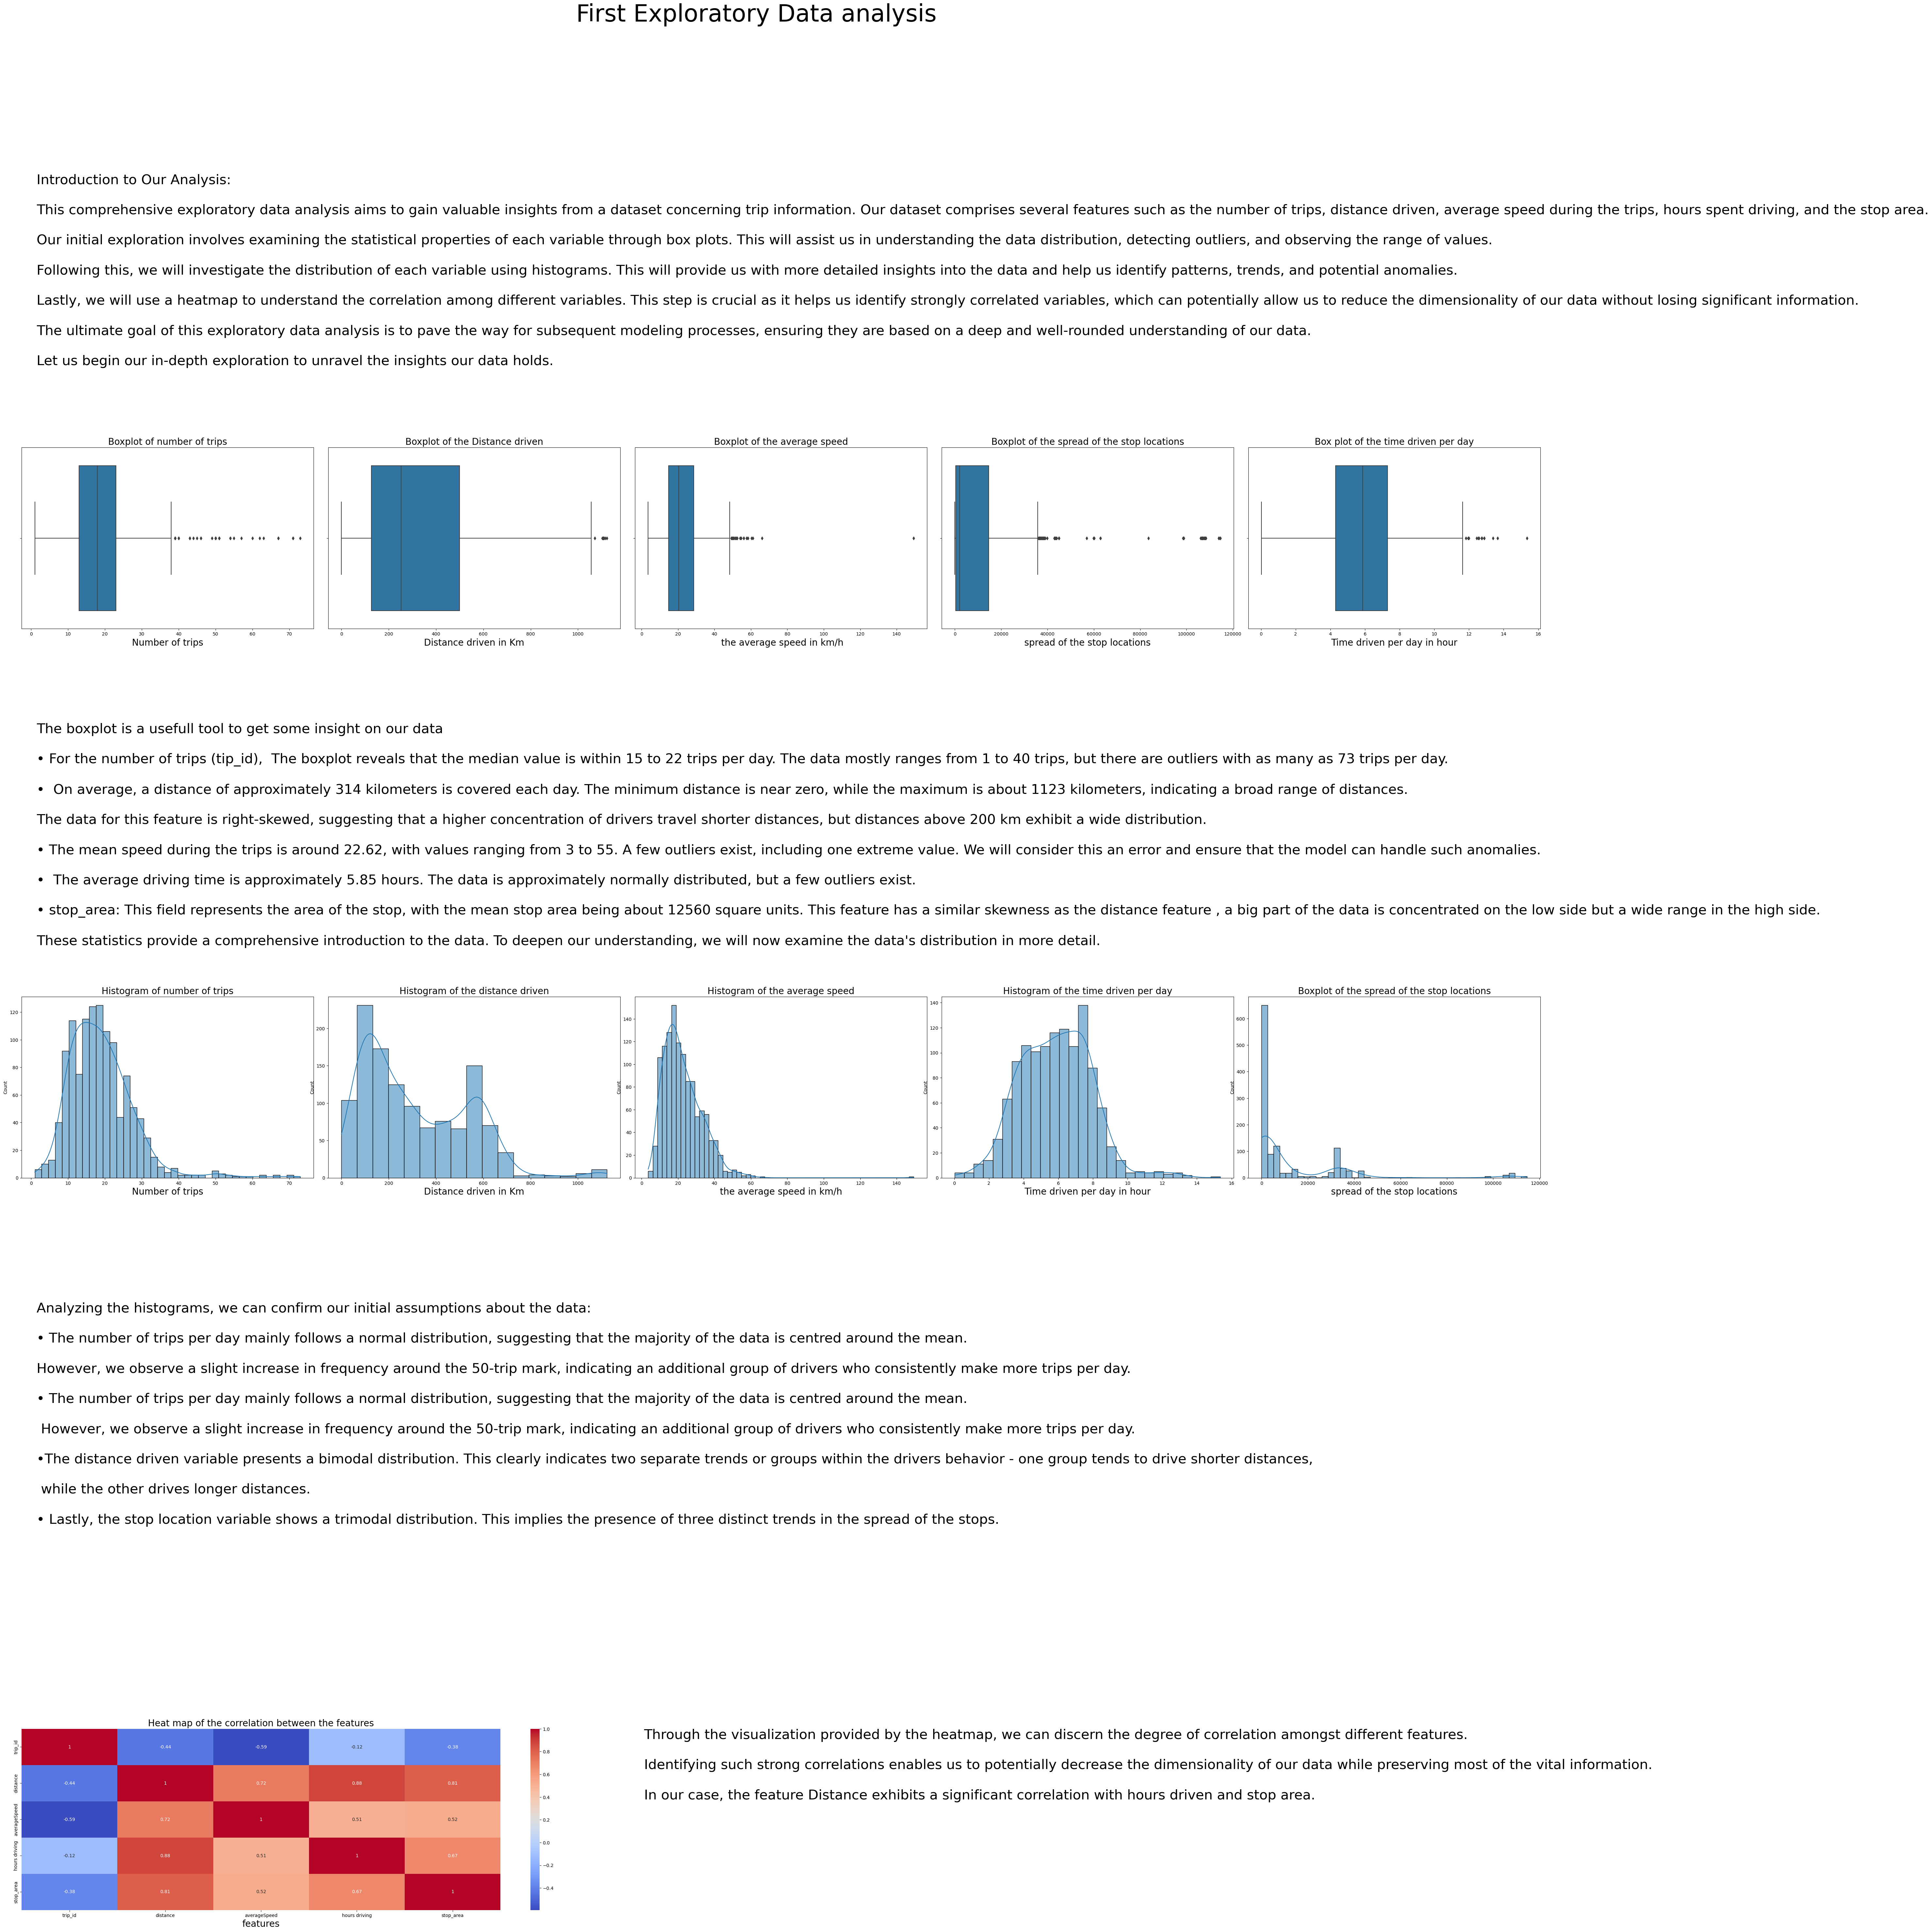

In [53]:
grid = plt.GridSpec(11, 5, wspace = 0.05, hspace = 0.01)

# Create the figure
fig = plt.figure(figsize = (60,80))
fig.suptitle("First Exploratory Data analysis", fontsize = 52)
# Create the axes
ax1 = fig.add_subplot(grid[1:2, 0])
ax2 = fig.add_subplot(grid[1:2, 1])
ax3 = fig.add_subplot(grid[1:2, 2])
ax4 = fig.add_subplot(grid[1:2, 4])
ax5 = fig.add_subplot(grid[1:2, 3])

# Create the boxplots for each variable
sns.boxplot(x='trip_id', data=summary_trips, ax= ax1)
sns.boxplot(x='distance', data=summary_trips, ax= ax2)
sns.boxplot(x='averageSpeed', data=summary_trips, ax= ax3)
sns.boxplot(x='hours driving', data=summary_trips,ax= ax4)
sns.boxplot(x='stop_area', data=summary_trips, ax= ax5)

# Text subplots
ax14= fig.add_subplot(grid[0, :5])
ax14.axis('off')
ax14.text(0.01, 1.5,

         'Introduction to Our Analysis:\n\n'

         'This comprehensive exploratory data analysis aims to gain valuable insights from a dataset concerning trip information. Our dataset comprises several features such as the number of trips, distance driven, average speed during the trips, hours spent driving, and the stop area.\n\n'
         
         'Our initial exploration involves examining the statistical properties of each variable through box plots. This will assist us in understanding the data distribution, detecting outliers, and observing the range of values.\n\n'
         
         'Following this, we will investigate the distribution of each variable using histograms. This will provide us with more detailed insights into the data and help us identify patterns, trends, and potential anomalies.\n\n'
         
         'Lastly, we will use a heatmap to understand the correlation among different variables. This step is crucial as it helps us identify strongly correlated variables, which can potentially allow us to reduce the dimensionality of our data without losing significant information.\n\n'
         
         'The ultimate goal of this exploratory data analysis is to pave the way for subsequent modeling processes, ensuring they are based on a deep and well-rounded understanding of our data.\n\n'
         
         'Let us begin our in-depth exploration to unravel the insights our data holds.\n\n',
         
         horizontalalignment='left', verticalalignment='top', fontsize=30)

ax6= fig.add_subplot(grid[3, :5])
ax6.axis('off')
ax6.text(0.01, 1.5,
         'The boxplot is a usefull tool to get some insight on our data \n\n'
         u'\u2022 For the number of trips (tip_id),  The boxplot reveals that the median value is within 15 to 22 trips per day. The data mostly ranges from 1 to 40 trips, but there are outliers with as many as 73 trips per day.\n\n'
         u'\u2022  On average, a distance of approximately 314 kilometers is covered each day. The minimum distance is near zero, while the maximum is about 1123 kilometers, indicating a broad range of distances.\n\n'
         'The data for this feature is right-skewed, suggesting that a higher concentration of drivers travel shorter distances, but distances above 200 km exhibit a wide distribution.\n\n'
         u'\u2022 The mean speed during the trips is around 22.62, with values ranging from 3 to 55. A few outliers exist, including one extreme value. We will consider this an error and ensure that the model can handle such anomalies.\n\n'
         u'\u2022  The average driving time is approximately 5.85 hours. The data is approximately normally distributed, but a few outliers exist.\n\n'
         u'\u2022 stop_area: This field represents the area of the stop, with the mean stop area being about 12560 square units. This feature has a similar skewness as the distance feature , a big part of the data is concentrated on the low side but a wide range in the high side.\n\n'
         u"These statistics provide a comprehensive introduction to the data. To deepen our understanding, we will now examine the data's distribution in more detail.",
         horizontalalignment='left', verticalalignment='top', fontsize=30)




# Bar plots
ax7 = fig.add_subplot(grid[4, 0])
ax8 = fig.add_subplot(grid[4, 1])
ax9 = fig.add_subplot(grid[4, 2])
ax10 = fig.add_subplot(grid[4, 3])
ax11 = fig.add_subplot(grid[4, 4])

sns.histplot(x='trip_id', data=summary_trips, kde=True,ax= ax7)
sns.histplot(x='distance', data=summary_trips, kde=True,ax= ax8)
sns.histplot(x='averageSpeed', data=summary_trips, kde=True,ax= ax9)
sns.histplot(x='hours driving', data=summary_trips, kde=True,ax= ax10)
sns.histplot(x='stop_area', data=summary_trips,kde=True,ax= ax11)

#text subplot
ax12 = fig.add_subplot(grid[6:7, :5])
ax12.axis('off')
ax12.text(0.01, 1.5,
          
         '\n\n'

'Analyzing the histograms, we can confirm our initial assumptions about the data:\n\n'

u'\u2022 The number of trips per day mainly follows a normal distribution, suggesting that the majority of the data is centred around the mean.\n\n'
          'However, we observe a slight increase in frequency around the 50-trip mark, indicating an additional group of drivers who consistently make more trips per day.\n\n'

u'\u2022 The number of trips per day mainly follows a normal distribution, suggesting that the majority of the data is centred around the mean.\n\n'
          ' However, we observe a slight increase in frequency around the 50-trip mark, indicating an additional group of drivers who consistently make more trips per day.\n\n'
u'\u2022The distance driven variable presents a bimodal distribution. This clearly indicates two separate trends or groups within the drivers behavior - one group tends to drive shorter distances,\n\n'
         ' while the other drives longer distances.\n\n'
u'\u2022 Lastly, the stop location variable shows a trimodal distribution. This implies the presence of three distinct trends in the spread of the stops.\n\n',
          horizontalalignment='left', verticalalignment='top', fontsize=30)



ax13 = fig.add_subplot(grid[8:9,:2])
correlation_matrix = summary_trips[['trip_id','distance','averageSpeed','hours driving','stop_area']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax13)
#text subplot
ax14 = fig.add_subplot(grid[8:9,2 :])
ax14.axis('off')
ax14.text(0.01, 1,
    
'Through the visualization provided by the heatmap, we can discern the degree of correlation amongst different features.\n\n'

'Identifying such strong correlations enables us to potentially decrease the dimensionality of our data while preserving most of the vital information. \n\n'

'In our case, the feature Distance exhibits a significant correlation with hours driven and stop area.\n\n',
         horizontalalignment='left', verticalalignment='top', fontsize=30)

ax1.set_title('Boxplot of number of trips', fontsize=20) # Change the title size here
ax2.set_title('Boxplot of the Distance driven', fontsize=20) # Change the title size here
ax3.set_title('Boxplot of the average speed', fontsize=20) # Change the title size here
ax4.set_title('Box plot of the time driven per day', fontsize=20) # Change the title size here
ax5.set_title('Boxplot of the spread of the stop locations', fontsize=20) # Change the title size here
ax7.set_title('Histogram of number of trips', fontsize=20) # Change the title size here
ax8.set_title('Histogram of the distance driven', fontsize=20) # Change the title size here
ax9.set_title('Histogram of the average speed', fontsize=20) # Change the title size here
ax10.set_title('Histogram of the time driven per day', fontsize=20) # Change the title size here
ax11.set_title('Boxplot of the spread of the stop locations', fontsize=20) # Change the title size here
ax13.set_title('Heat map of the correlation between the features', fontsize=20) # Change the title size here
sizelabel=20
ax1.set_xlabel('Number of trips', fontsize=sizelabel)
ax2.set_xlabel('Distance driven in Km', fontsize=sizelabel)
ax3.set_xlabel(' the average speed in km/h', fontsize=sizelabel)
ax4.set_xlabel('Time driven per day in hour', fontsize=sizelabel)
ax5.set_xlabel('spread of the stop locations', fontsize=sizelabel)
ax7.set_xlabel('Number of trips', fontsize=sizelabel)
ax8.set_xlabel('Distance driven in Km', fontsize=sizelabel)
ax9.set_xlabel('the average speed in km/h', fontsize=sizelabel)
ax10.set_xlabel('Time driven per day in hour', fontsize=sizelabel)
ax11.set_xlabel('spread of the stop locations', fontsize=sizelabel)
ax13.set_xlabel("features", fontsize=sizelabel)




fig.savefig("First exploratory analysis.pdf", format='pdf')

plt.show()


### Feature Engineering:

In this phase, our objective is to design features that will yield relevant insights for our model. It's beneficial to approach this task with the end user's requirements in mind. In our specific context, the following features appear to be of substantial relevance:

### Performance Metrics

##### Hours Driven per working hours (Hours_driven_per_day)
This is calculated by dividing the total hours driven by the length of a workday. This metric provides insight into the driver's level of activity during their working hours.


### General Behavior

##### Working_hours
This feature indicates how long the shift is, as well as helps to create more standardized features.

##### Number of Trips per working hours (nb_trips_per_work_Day)
This indicator shows the total number of trips started in relation to the working hours. It is useful for understanding the frequency of trips initiated by the drivers during their work hours.

##### Average Driving Duration (avg_drivingDuration) & ##### Average Stop Duration (avg_stopDuration)

This represents the average length of time spent driving and idling on each trip. It provides a measure of the typical duration of the driver's trips, which could indicate what type of assignments are given to the drivers.

##### Start Hour:
This represents the hour of the day when the trip commences. It can provide an understanding of the driver's preferred or most active time of day for initiating trips.


In [379]:
# Create the additional features

summary_trips["workday"]=((summary_trips["stop"]-summary_trips["start"])).dt.total_seconds()/3600

summary_trips['efficiency']=summary_trips["distance"]/summary_trips['hours driving']

summary_trips['Hours_driven_per_day']=summary_trips["hours driving"]/summary_trips['workday']

summary_trips['nb_trips_per_work_Day']=summary_trips['trip_id'] / summary_trips['workday']

summary_trips['start_hour'] = summary_trips['start'].dt.hour








After we've established the 'workday' feature, it's time for me to refine our dataset. I will exclude data from drivers who seem to be working longer than what is legally or physically viable, like 18 hours, or those who work less than 3 hours. 

There can be anomalies in the data, such as when drivers forget to log off their Geotabs, which results in abnormally long shifts. Additionally, shifts less than 3 hours might occur, perhaps due to an emergency or an unexpected event causing the driver to end their day prematurely. By setting these thresholds, I ensure that the dataset accurately represents standard driving behavior, which is crucial for our analysis.

In [350]:

removed= len(summary_trips[summary_trips['workday'] > 18])+ len(summary_trips[summary_trips['workday'] < 3])

summary_trips = summary_trips.drop(summary_trips[summary_trips['workday'] > 18].index)
summary_trips = summary_trips.drop(summary_trips[summary_trips['workday'] < 3].index)

print("Trips removed: {}".format(removed))


Trips removed: 106


#### Sytematically remove correlated features
As a next step, I'll systematically tackle correlated features within our dataset. High correlation between different features can lead to issues of multicollinearity in our model, which could hinder its performance. 

I'll identify pairs of features that have a high correlation coefficient and, in each pair, remove the one that is less informative or relevant to our end goal. This way, I can make sure that each feature in our dataset contributes unique and valuable information to our model, improving its ability to yield accurate insights.

In [351]:
# Compute correlation matrix
correlation_matrix = summary_trips.corr()

# Create a mask to ignore self-
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
tri_df = correlation_matrix.mask(mask)

# List column pairs with correlation coefficient > 0.7
corr_pairs = [(column, row) for column in tri_df.columns for row in tri_df.index if abs(tri_df.loc[row, column]) > 0.8]

# Print out pairs
for pair in corr_pairs:
    print(pair)

('trip_id', 'nb_trips_per_work_Day')
('distance', 'hours driving')
('distance', 'avg_drivingDuration')
('distance', 'stop_area')


In [352]:
correlated_pairs = [
     ('trip_id', 'nb_trips_per_work_Day'),
('distance', 'hours driving'),
('distance', 'avg_drivingDuration'),
('distance', 'stop_area')
]

# We'll make a set to hold the features to be dropped
to_drop = set()

# Loop over the pairs
for pair in correlated_pairs:
    # We'll drop the second feature from each pair
    to_drop.add(pair[1])
    
# Now we'll drop these from the dataframe
X = summary_trips.drop(columns=to_drop)


### Preprocessing
In the preprocessing phase, I'll take a series of steps to prepare our data for modeling. This involves scaling numerical features to ensure that no particular feature dominates the model due to its range. If we had any categorical features, I would convert them into a numerical format, but we do not have any of these in our model.

Additionally, I'll handle any remaining missing values or infinite values in our dataset.

The objective here is to create a final dataset that's clean, properly formatted, and ready for effective modeling.

I've observed that occasionally, certain features connected to the 'stop_area' contain infinite values due to division by zero. To rectify this, I will replace these infinite values with zero.

In [353]:
 X=X.replace(np.inf,0)


#### Standardization
The next step in our preprocessing involves standardization. This process adjusts our features so they have a mean of 0 and a standard deviation of 1. Standardization is crucial because it brings all features onto the same scale, ensuring that no particular feature disproportionately influences the model due to its larger numerical range. This allows for a fair comparison and accurate predictions from our model.

In [354]:
#we are only standardizing numerical values
features_to_scale= X.select_dtypes(exclude=['object', 'datetime64[ns, US/Eastern]']).columns.tolist()


In [355]:
# Create a scaler object
scaler = StandardScaler()

# Fit and transform the features to scale
X_scaled = scaler.fit_transform(X[features_to_scale])

# Create a DataFrame of the scaled features
X_scaled = pd.DataFrame(X_scaled, columns=features_to_scale)




#### Dimensionality Reduction
Following standardization, I'll focus on dimensionality reduction. This step aims to reduce the number of input variables in our dataset. While retaining as much of the relevant information as possible, we compress the data to a more manageable size. I chose to employ Principal Component Analysis (PCA) . Dimensionality reduction can help improve model performance, reduce overfitting, and make the data easier to visualize and understand.

###### PCA & explained variance ratio
With the help of the explained variance ratio, I can determine the optimal number of components that contribute the most valuable information. This ratio illustrates the amount of variance each principal component retains from the original dataset, which aids in deciding the number of components we should keep for our analysis.

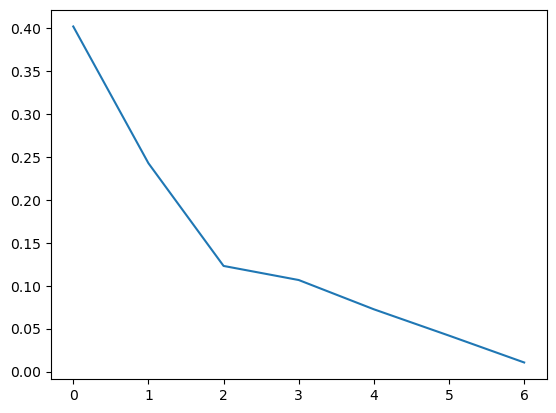

In [361]:
pca= PCA()
X= pca.fit_transform(X_scaled)
plt.plot(pca.explained_variance_ratio_)

Based on the graphical analysis, we should focus on two principal components since the variance components after 2 does not give as much as information for the added complexity

In [362]:
pca= PCA(n_components=2)
X= pca.fit_transform(X_scaled)


Below, you'll find a plot of the principal components prior to applying the clustering algorithm. This gives us a snapshot of our data's structure in the reduced-dimensional space. After running the clustering algorithm, we can revisit this visualization to see how our clusters have formed within this structure.

<AxesSubplot:>

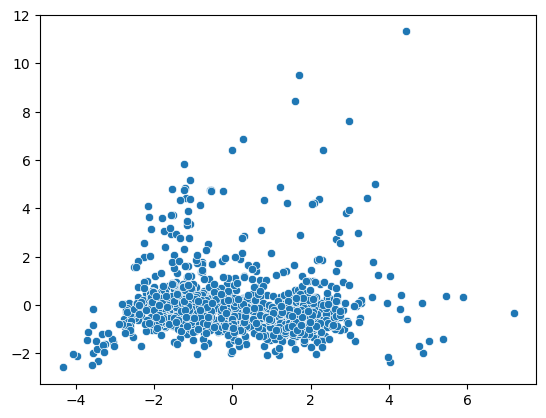

In [363]:
sns.scatterplot(
    x=X[:, 0], 
    y=X[:,1 ],
  )

### Model training and cross validation

My plan is to use the K-means clustering algorithm for our project. The evaluation metrics that I'll consider include distortion, silhouette score, and the Calinski-Harabasz index.

In terms of distortion, my aim is to find a setup that minimizes this measure, indicating that the clusters have smaller distances within them. The trick here is to find a sweet spot between having a manageable number of clusters and minimizing distortion.

When it comes to the silhouette score, I'm aiming for a higher score. This would mean that our data points are well aligned with their own clusters and poorly matched with adjacent clusters. 

As for the Calinski-Harabasz index, my target is to maximize this score, indicating that the clusters are well-separated. However, considering the nature of the driving behavior data, I do anticipate some overlap among the clusters.

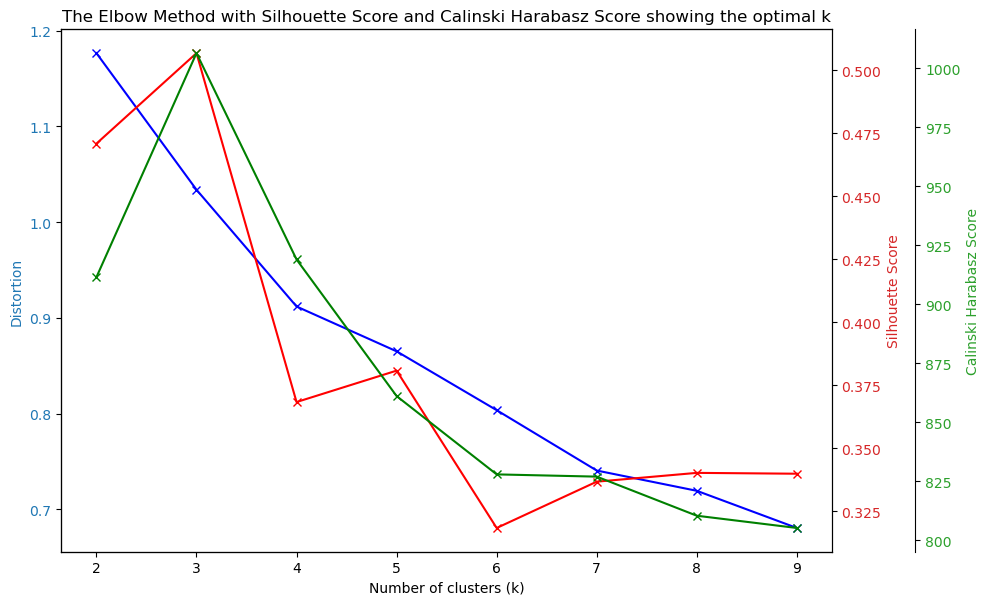

In [359]:
# Identify the optimal number of clusters using the Elbow method
distortions = []
silhouette_scores = []  # silhouette scores
calinski_scores = []  # calinski harabasz scores

K = range(2,10)  # silhouette score and calinski_harabasz_score are not defined for a single cluster
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # silhouette score calculation
    labels = kmeanModel.labels_
    silhouette_scores.append(silhouette_score(X, labels, metric = 'euclidean'))

    # calinski harabasz score calculation
    calinski_scores.append(calinski_harabasz_score(X, labels))
   
# Plot the elbow, silhouette score and calinski harabasz score
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Distortion', color=color)
ax1.plot(K, distortions, 'bx-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)  
ax2.plot(K, silhouette_scores, 'rx-')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))    
ax3.set_ylabel('Calinski Harabasz Score', color=color)  
ax3.plot(K, calinski_scores, 'gx-')
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('The Elbow Method with Silhouette Score and Calinski Harabasz Score showing the optimal k')
plt.show()


Based on the graph, there are two intriguing points that I want to highlight. We could go with 3 clusters, which gives us the highest silhouette score and Calinski-Harabasz index, indicating well-defined and separate clusters. However, it also results in a high level of distortion. This means we'd have three distinct segments of drivers to base our policy on.

Alternatively, choosing 5 clusters will lead to less distortion, and the decrease in the other metrics is not too significant. In the context of our project, it's realistic to expect similarities among trips and, consequently, some overlap among clusters. The five-cluster solution would provide a more nuanced segmentation of drivers, which might prove valuable for policy formulation.

Lets train 2 models, one with 3 cluster and one with K= 5

In [365]:

# Specify the number of clusters 
num_clusters_3= 3
num_clusters_5= 5
# Create a KMeans object
kmeans_3 = KMeans(n_clusters=num_clusters_3, random_state=42)
kmeans_5 = KMeans(n_clusters=num_clusters_5, random_state=42)
# Fit the model to the data
kmeans_3.fit(X)
kmeans_5.fit(X)
# Predicting the clusters
labels = kmeans_3.predict(X)
labels_5 = kmeans_5.predict(X)

# Get the cluster assignments for each data point
summary_trips['kmeans_cluster'] = kmeans_3.labels_
summary_trips['kmeans_cluster_5'] = kmeans_5.labels_


I'll proceed to implement both the three-cluster and five-cluster models on our PCA plot.

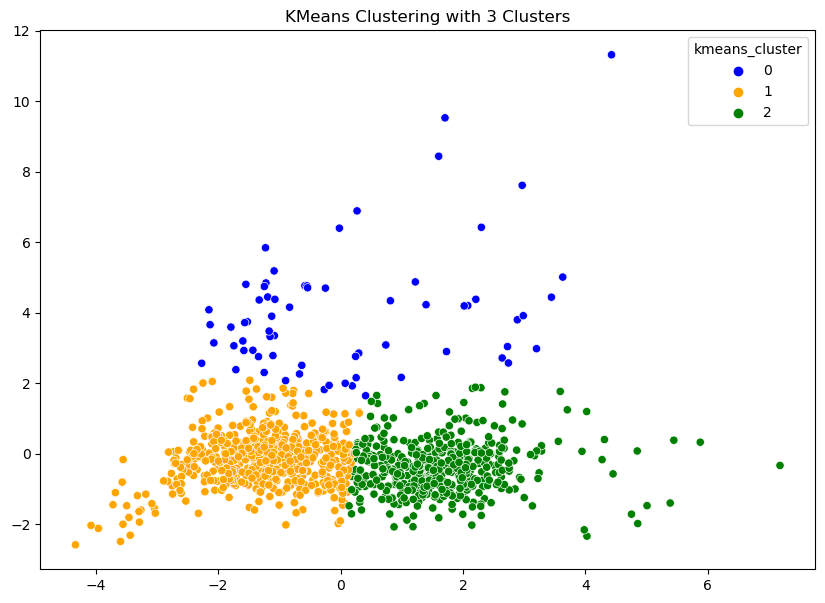

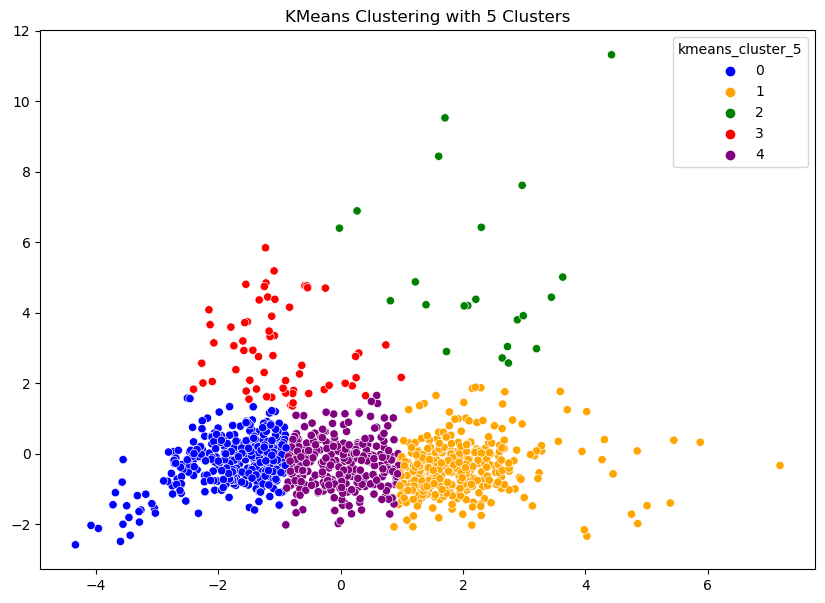

In [385]:
color_3=['blue', 'orange', 'green']
color_5=['blue', 'orange', 'green','red','purple']

# Create the first figure
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X[:, 0], 
    y=X[:, 1],
    hue=summary_trips['kmeans_cluster'],
    palette=color_3,
    legend="full",
)
plt.title('KMeans Clustering with 3 Clusters')
plt.show()

# Create the second figure
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X[:, 0], 
    y=X[:, 1],
    hue=summary_trips['kmeans_cluster_5'],
    palette=color_5,
    legend="full",
)
plt.title('KMeans Clustering with 5 Clusters')
plt.show()


While the principal components give a tidy structure making it easier for us to see the clusters, the true test is how these models fare when applied to the 'summary_trips' dataframe. This dataframe contains the original, high-dimensional data, so seeing how our clusters form in this space will give me a more complete picture of how well our models are performing.

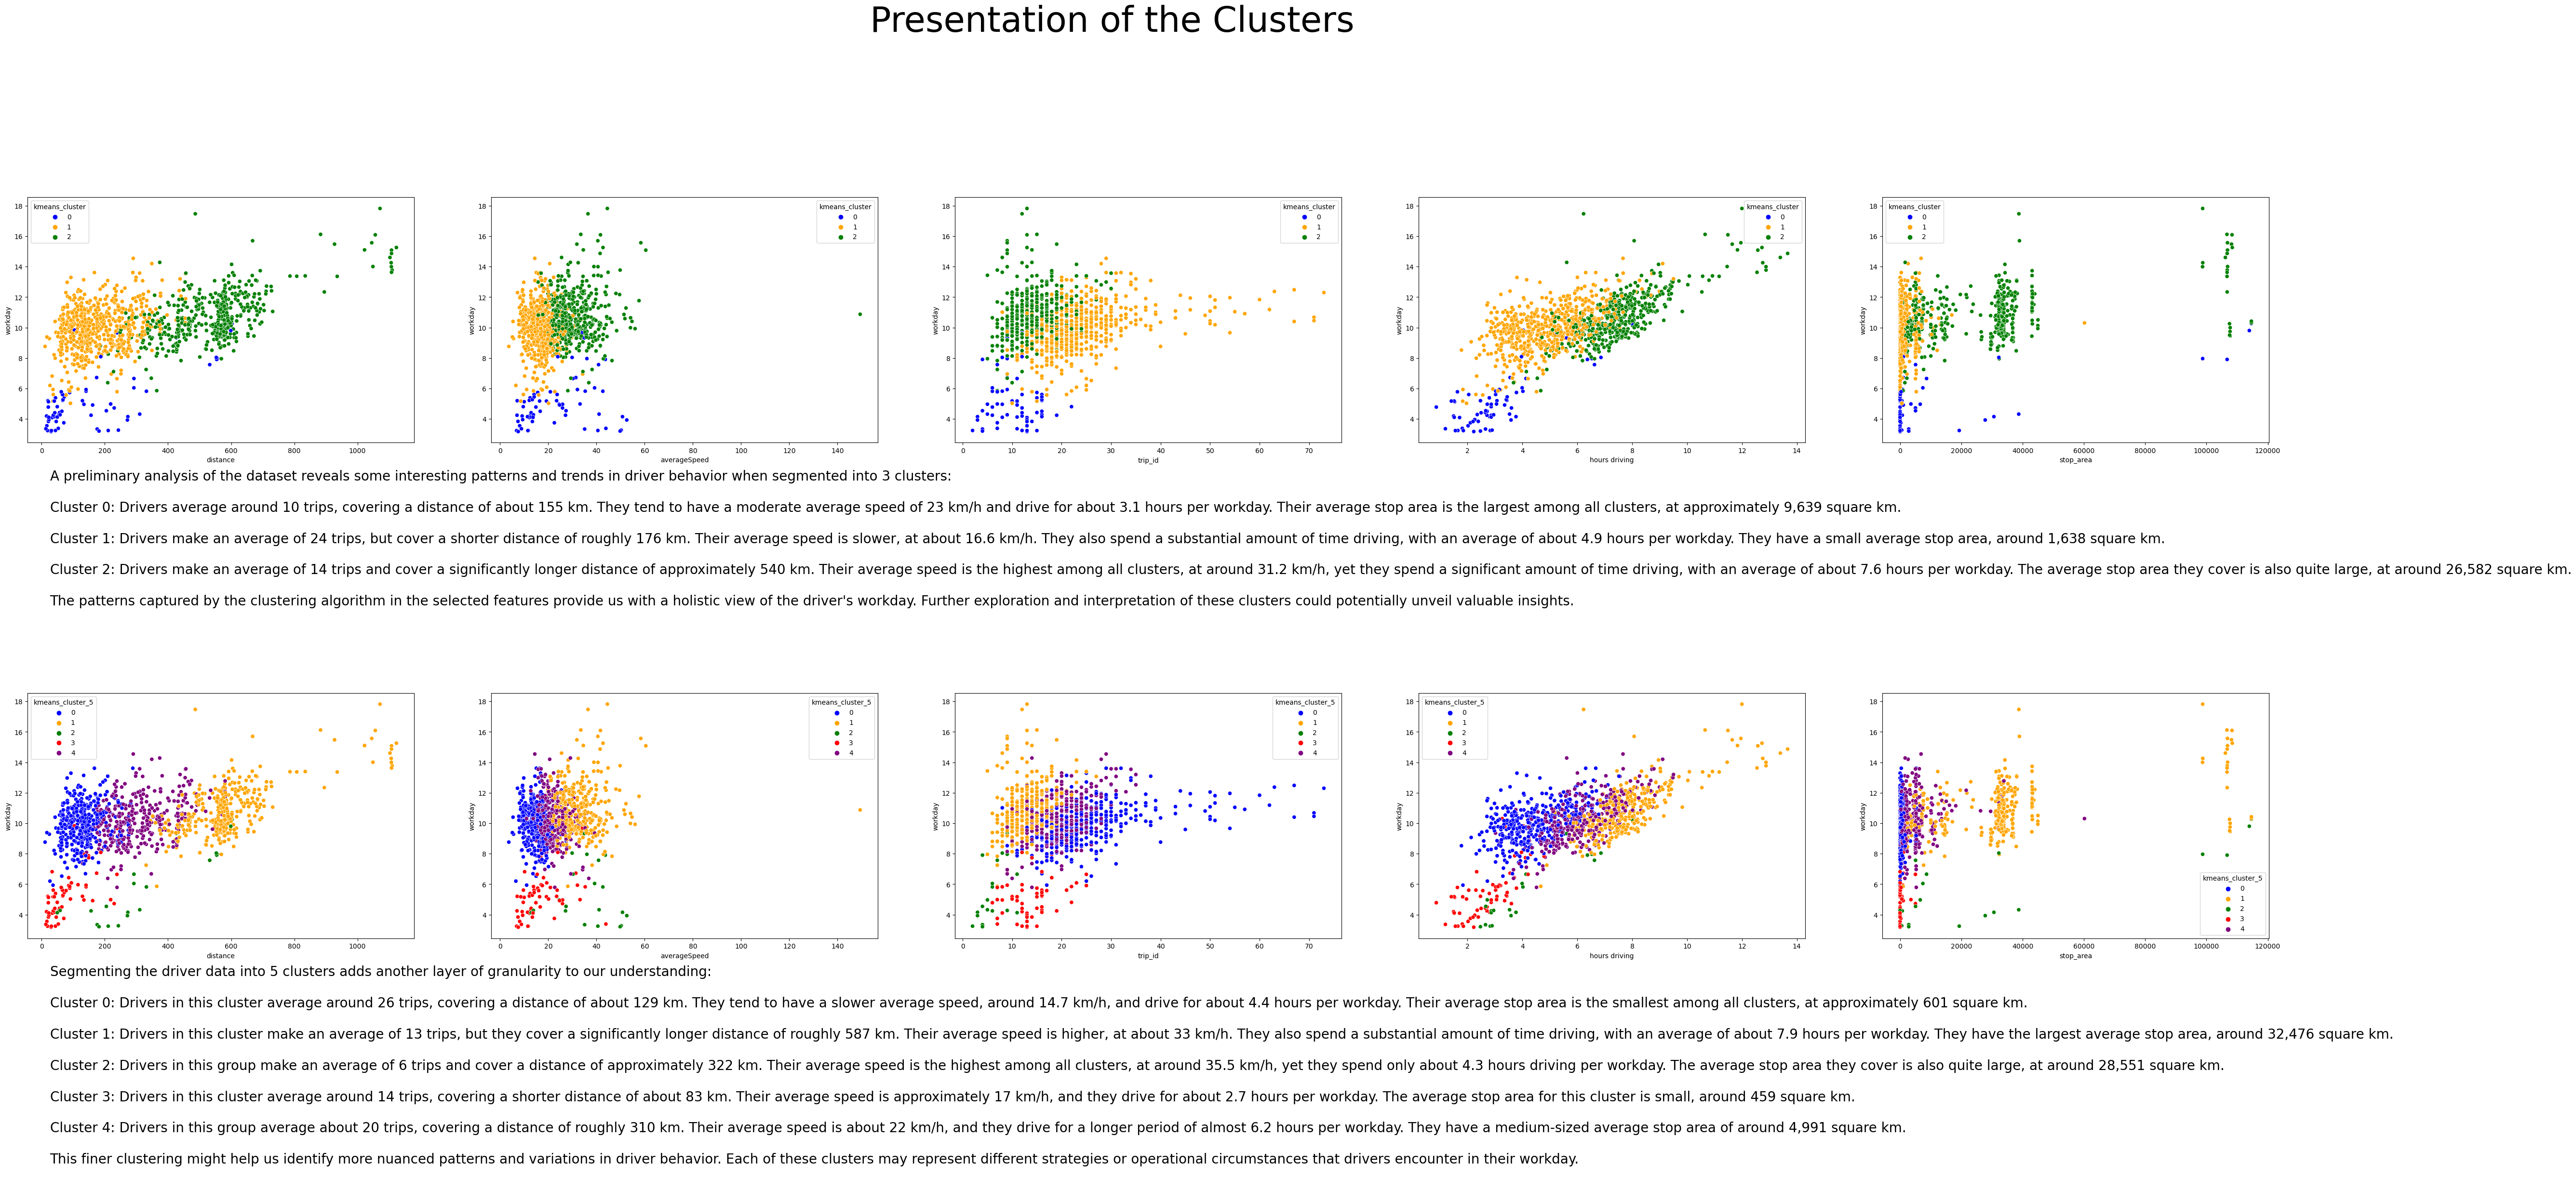

In [393]:
# Create the figure
fig = plt.figure(figsize = (60,40))
fig.suptitle("Presentation of the Clusters", fontsize = 52)

# Create the axes
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[0, 2])
ax4 = fig.add_subplot(grid[0, 3])
ax5 = fig.add_subplot(grid[0, 4])

# Create the scatterplots for each variable for the 3 cluster solution
for ax, var in zip([ax1, ax2, ax3, ax4, ax5], ['distance', 'averageSpeed', 'trip_id', 'hours driving', 'stop_area']):
    sns.scatterplot(x=var, y= 'workday', hue= 'kmeans_cluster', palette= color_3, data=summary_trips, ax=ax)

# Text subplot
ax6 = fig.add_subplot(grid[1, :])
ax6.axis('off')
ax6.text(0.01, 0.9, 
         "A preliminary analysis of the dataset reveals some interesting patterns and trends in driver behavior when segmented into 3 clusters:\n\n"
         "Cluster 0: Drivers average around 10 trips, covering a distance of about 155 km. They tend to have a moderate average speed of 23 km/h and drive for about 3.1 hours per workday. Their average stop area is the largest among all clusters, at approximately 9,639 square units.\n\n"
         "Cluster 1: Drivers make an average of 24 trips, but cover a shorter distance of roughly 176 km. Their average speed is slower, at about 16.6 km/h. They also spend a substantial amount of time driving, with an average of about 4.9 hours per workday. They have a small average stop area, around 1,638 square units.\n\n"
         "Cluster 2: Drivers make an average of 14 trips and cover a significantly longer distance of approximately 540 km. Their average speed is the highest among all clusters, at around 31.2 km/h, yet they spend a significant amount of time driving, with an average of about 7.6 hours per workday. The average stop area they cover is also quite large, at around 26,582 square units.\n\n"
         "The patterns captured by the clustering algorithm in the selected features provide us with a holistic view of the driver's workday. Further exploration and interpretation of these clusters could potentially unveil valuable insights.",
         horizontalalignment='left', verticalalignment='top', fontsize=20)

# Create the axes
ax7 = fig.add_subplot(grid[2, 0])
ax8 = fig.add_subplot(grid[2, 1])
ax9 = fig.add_subplot(grid[2, 2])
ax10 = fig.add_subplot(grid[2, 3])
ax11 = fig.add_subplot(grid[2, 4])

# Create the scatterplots for each variable for the 5 cluster solution
for ax, var in zip([ax7, ax8, ax9, ax10, ax11], ['distance', 'averageSpeed', 'trip_id', 'hours driving', 'stop_area']):
    sns.scatterplot(x=var, y= 'workday', hue= 'kmeans_cluster_5', palette= color_5, data=summary_trips, ax=ax)

# Text subplot
ax12 = fig.add_subplot(grid[3, :])
ax12.axis('off')
ax12.text(0.01, 0.9, 
         "Segmenting the driver data into 5 clusters adds another layer of granularity to our understanding:\n\n"
         "Cluster 0: Drivers in this cluster average around 26 trips, covering a distance of about 129 km. They tend to have a slower average speed, around 14.7 km/h, and drive for about 4.4 hours per workday. Their average stop area is the smallest among all clusters, at approximately 601 square units.\n\n"
         "Cluster 1: Drivers in this cluster make an average of 13 trips, but they cover a significantly longer distance of roughly 587 km. Their average speed is higher, at about 33 km/h. They also spend a substantial amount of time driving, with an average of about 7.9 hours per workday. They have the largest average stop area, around 32,476 square units.\n\n"
         "Cluster 2: Drivers in this group make an average of 6 trips and cover a distance of approximately 322 km. Their average speed is the highest among all clusters, at around 35.5 km/h, yet they spend only about 4.3 hours driving per workday. The average stop area they cover is also quite large, at around 28,551 square units.\n\n"
         "Cluster 3: Drivers in this cluster average around 14 trips, covering a shorter distance of about 83 km. Their average speed is approximately 17 km/h, and they drive for about 2.7 hours per workday. The average stop area for this cluster is small, around 459 square units.\n\n"
         "Cluster 4: Drivers in this group average about 20 trips, covering a distance of roughly 310 km. Their average speed is about 22 km/h, and they drive for a longer period of almost 6.2 hours per workday. They have a medium-sized average stop area of around 4,991 square units.\n\n"
         "This finer clustering might help us identify more nuanced patterns and variations in driver behavior. Each of these clusters may represent different strategies or operational circumstances that drivers encounter in their workday.",
         horizontalalignment='left', verticalalignment='top', fontsize=20)

# Show the figure
plt.show()
fig.savefig("Presentation of the Clusters.pdf", format='pdf')


The method a transportation company employs to assess its drivers can vary depending on the specific nature of their work. The following code allows for a versatile comparison across any metrics of interest.

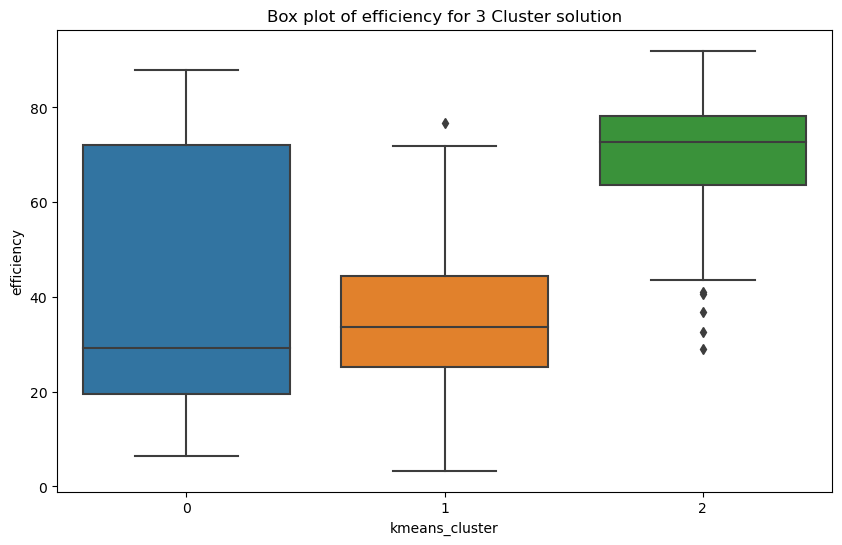

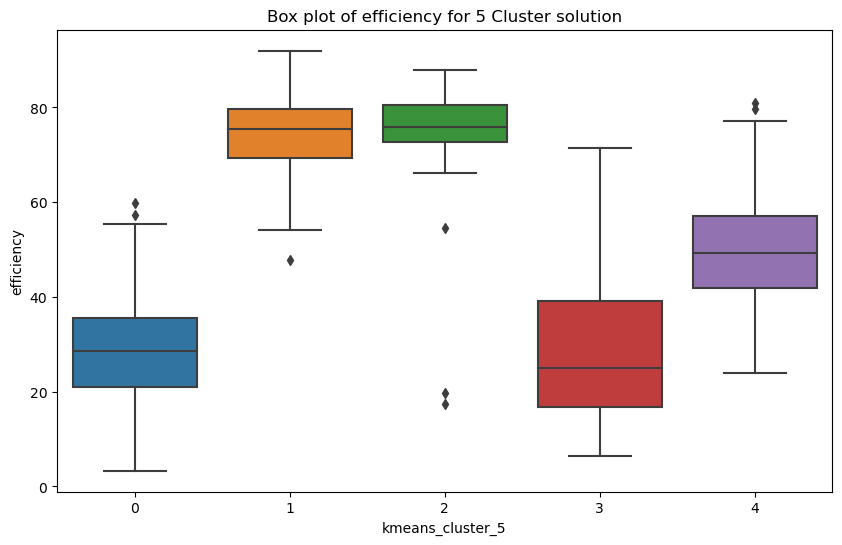

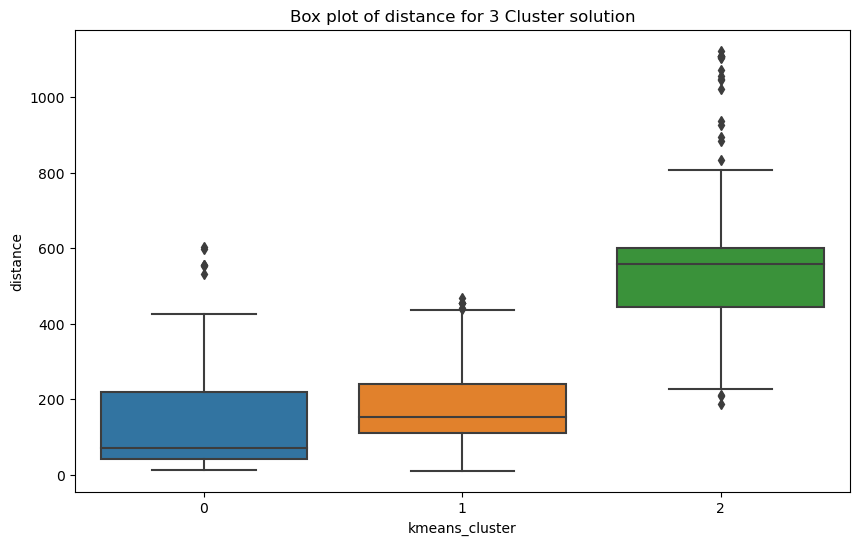

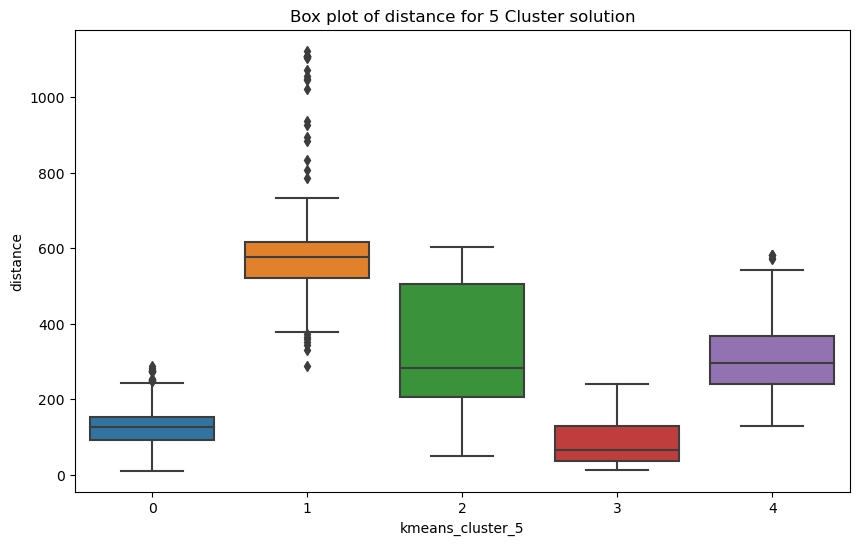

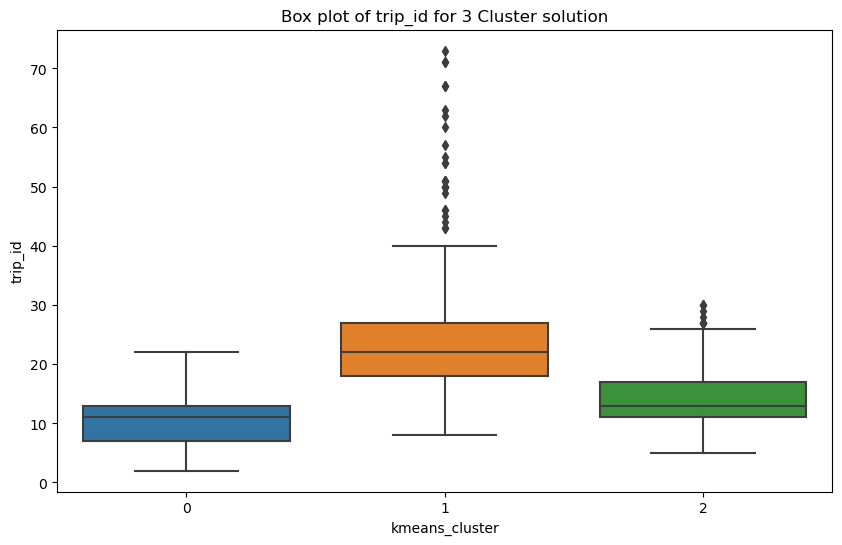

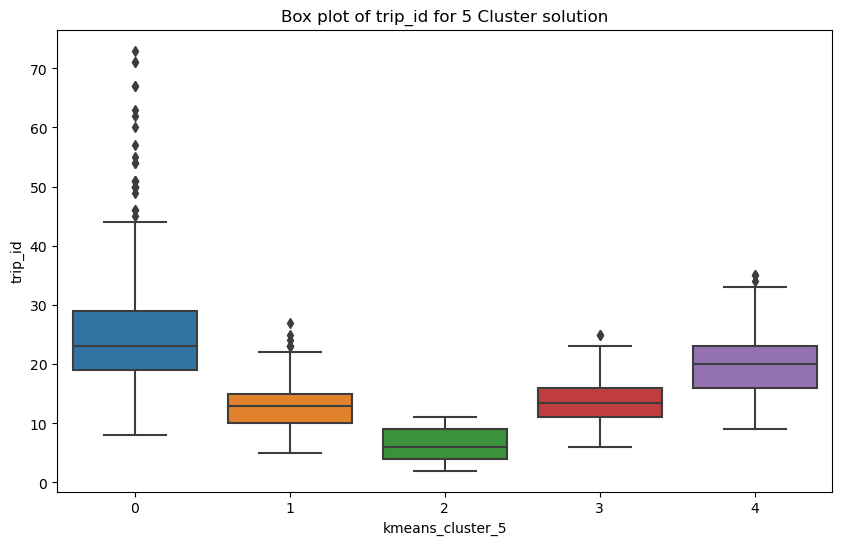

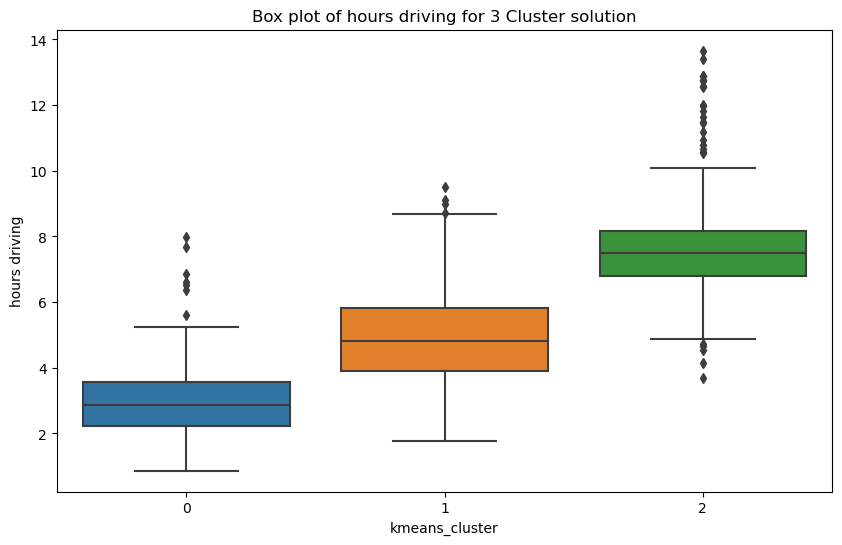

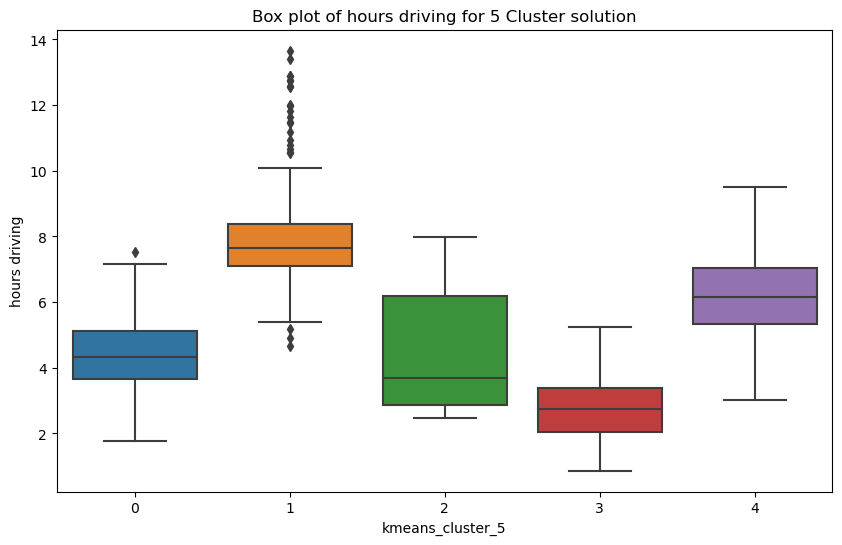

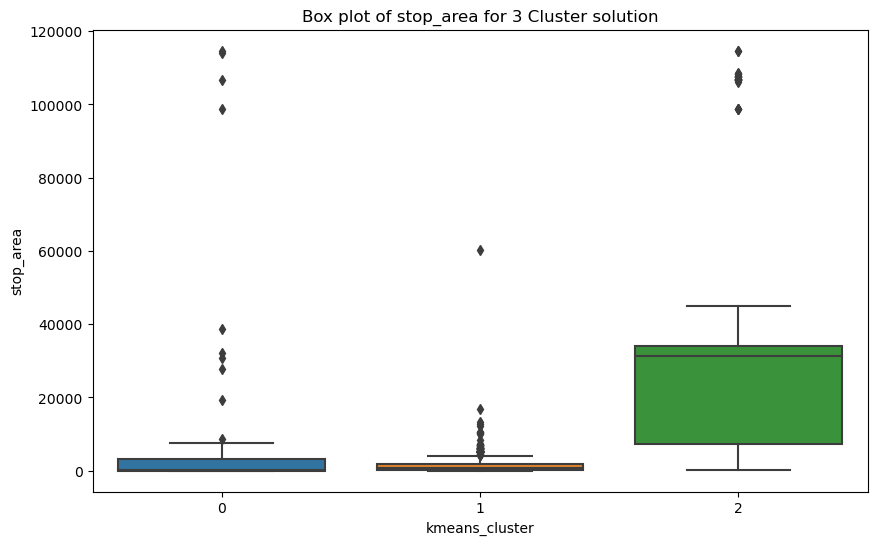

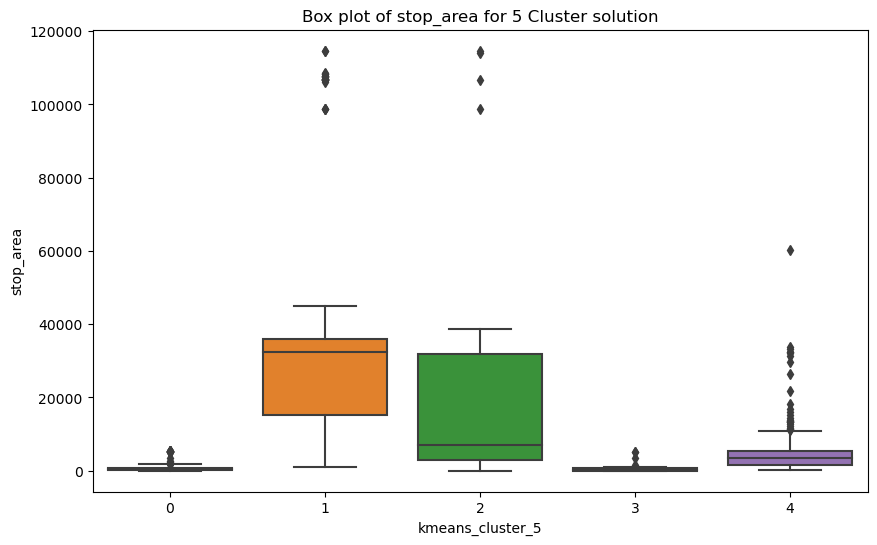

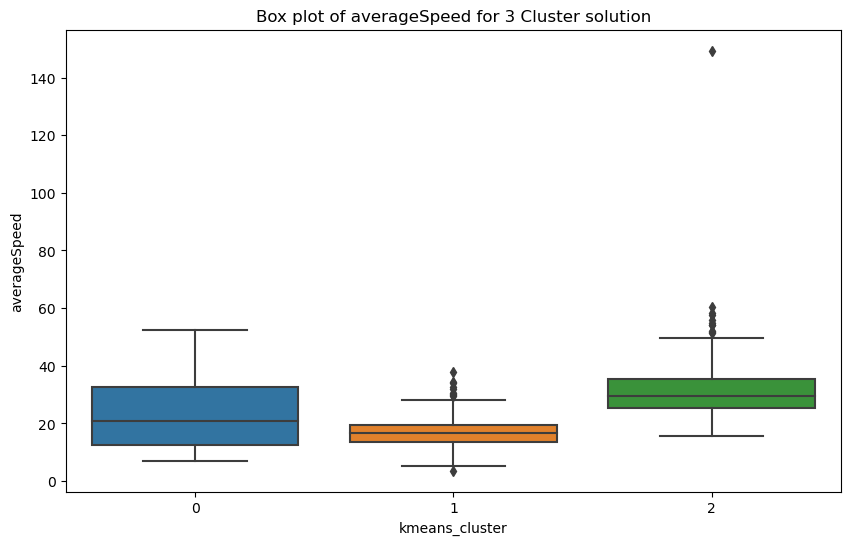

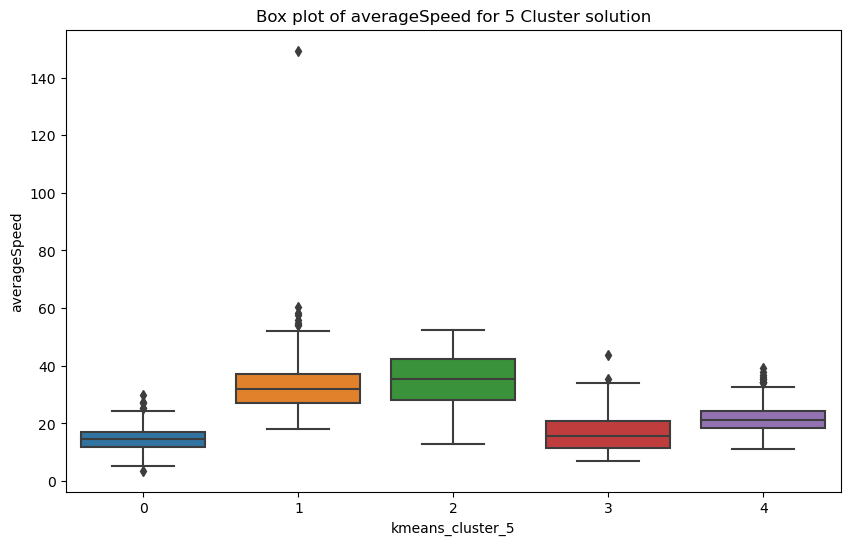

In [387]:
relevant_metrics = ['efficiency']  # Add other numerical columns here

for col in relevant_metrics:
    # Create the first figure
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='kmeans_cluster', y=col, data=summary_trips)
    plt.title('Box plot of '+col+' for 3 Cluster solution')
    plt.show()
    
    # Create the second figure
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='kmeans_cluster_5', y=col, data=summary_trips)
    plt.title('Box plot of '+col+' for 5 Cluster solution')
    plt.show()


In [402]:


summary_trips.to_csv('./Data/cluster.csv')

#### Suggested Approach for Implementing the Model:

1. Firstly, let's run the model on the entire fleet. This will provide an initial overview of different driving styles within the fleet.

2. After that, let's compare the results from the model with what we already know about our business. If there are discrepancies, we can adjust the model or even consider adding more relevant features, such as driver's contract type or their specific routes.

3. With the clusters identified by the model, we can set different goals that are appropriate for each group. These objectives should reflect the reality of each cluster's workday and what we want to achieve.

4. The next step is a closer look at each driver within their cluster. If we find drivers that, should not be in a certain cluster, based on what type of work is assigned to them, we could provide additional training or implement measures to help them move to their right cluster.

5. Finally, as we get more data or when the conditions of our business change, we should update the model accordingly. This will ensure the model remains relevant and useful for our decision-making process.

This is a collaborative effort, so your insights about the business and the drivers are crucial to make this model work best for us. Your feedback is always welcome, and together, we'll improve this model to better serve our needs.